### GIS-2 Final Project


Step 1: Data acquisition and cleaning 

In [172]:
# Import necessary libraries for GIS data processing
import geopandas as gpd
import osmnx as ox
import rasterio
import requests
import zipfile
import os
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Set up OSMnx settings
ox.settings.log_console = True
ox.settings.use_cache = True

# Define data directory
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)

# Define place name
PLACE_NAME = 'Graz, Austria'

# Define CRS for metric projections
# For Austria: EPSG:31256 (MGI / Austria Lambert) is recommended for official geodetic work
# Alternative: EPSG:32633 (UTM zone 33N) - but less accurate for Austria
CRS_METRIC = 'EPSG:31256'  # MGI / Austria Lambert - official Austrian CRS

In [173]:
# Load Graz city boundary and districts
graz_boundary = ox.geocode_to_gdf(PLACE_NAME).to_crs(CRS_METRIC)

# All 18 districts of Graz
OFFICIAL_DISTRICTS = [
    "Innere Stadt", "St. Leonhard", "Sankt Leonhard", "Geidorf", "Lend", "Gries",
    "Jakomini", "Liebenau", "St. Peter", "Sankt Peter", "Waltendorf", "Ries",
    "Mariatrost", "Andritz", "Gösting", "Eggenberg", "Wetzelsdorf", "Straßgang", "Puntigam"
]

# Get administrative boundaries from OSM and filter to Graz districts
all_admin = ox.features_from_place(PLACE_NAME, tags={'boundary': 'administrative'})
all_admin = all_admin[all_admin.geometry.type.isin(['Polygon', 'MultiPolygon'])].to_crs(CRS_METRIC)

districts = all_admin[all_admin['name'].isin(OFFICIAL_DISTRICTS)][['name', 'geometry']].copy()
districts = districts[districts.is_valid].reset_index(drop=True)

print(f"✓ Loaded {len(districts)} districts (total available: {len(OFFICIAL_DISTRICTS)})")

✓ Loaded 17 districts (total available: 19)


In [174]:
# Load medical facilities from OSM
print("Loading medical facilities...")

#medical = ox.features_from_place(PLACE_NAME, tags={'amenity': ['hospital', 'clinic', 'doctors', 'pharmacy']})
#medical = medical[medical.geometry.type == 'Point'].to_crs(CRS_METRIC)

# Load medical facilities from OSM and convert to metric CRS
medical = ox.features_from_place(
    PLACE_NAME,
    tags={'amenity': ['hospital', 'clinic', 'doctors', 'pharmacy']}
).to_crs(CRS_METRIC)

# Separate points and polygons
medical_points = medical[medical.geometry.type == 'Point']
medical_polygons = medical[medical.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Use centroids for polygon geometries
medical_polygons = medical_polygons.copy()
medical_polygons['geometry'] = medical_polygons.geometry.centroid

# Combine points and centroids into one GeoDataFrame
medical = pd.concat([medical_points, medical_polygons], ignore_index=True)

# Remove duplicates
medical['geom_str'] = medical['geometry'].astype(str)
medical = medical.drop_duplicates(subset=['geom_str']).drop('geom_str', axis=1)



# Inspect key OSM columns
print("Columns present:",
      [c for c in medical.columns
       if c in ['amenity', 'healthcare', 'healthcare:speciality']])

# Unique main amenity types
print("amenity:", sorted(medical['amenity'].dropna().unique()))

# Unique healthcare types (if present)
if 'healthcare' in medical.columns:
    print("healthcare:", sorted(medical['healthcare'].dropna().unique()))

# Unique healthcare specialties (if present)
if 'healthcare:speciality' in medical.columns:
    print("healthcare:speciality:", sorted(medical['healthcare:speciality'].dropna().unique()))

# Check geometry types (Point vs Polygon)
medical_all = ox.features_from_place(
    PLACE_NAME,
    tags={'amenity': ['hospital', 'clinic', 'doctors', 'pharmacy']}
)
print(medical_all.geometry.type.value_counts())



# Classify facility type
def classify_facility(row):
    name = str(row.get('name', '')).lower()
    amenity = str(row.get('amenity', '')).lower()
    if 'hospital' in name or 'krankenhaus' in name: return 'Hospital'
    if amenity == 'pharmacy' or 'apotheke' in name: return 'Pharmacy'
    if amenity == 'doctors' or 'arzt' in name: return 'Doctor'
    return 'Clinic'

medical['type'] = medical.apply(classify_facility, axis=1)
medical = medical[['name', 'type', 'geometry']].dropna(subset=['name']).reset_index(drop=True)

print(f"✓ Total facilities: {len(medical)}")
for t in medical['type'].unique():
    print(f"  • {t}: {len(medical[medical['type'] == t])}")

Loading medical facilities...
Columns present: ['amenity', 'healthcare', 'healthcare:speciality']
amenity: ['clinic', 'doctors', 'hospital', 'pharmacy']
healthcare: ['alternative', 'blood_donation', 'centre', 'clinic', 'doctor', 'hospital', 'laboratory', 'pharmacy', 'physiotherapist', 'psychotherapist', 'therapist']
healthcare:speciality: ['acupuncture', 'acupuncture;general;neurology;psychiatry', 'anaesthetics', 'anaesthetics;general', 'anaesthetics;psychiatry;trauma', 'ayurveda', 'biochemistry', 'blood_check', 'cardiology', 'cardiology;internal', 'child_psychiatry;general', 'child_psychiatry;psychiatry;neurology;youth_psychiatry', 'dentist', 'dermatology', 'dermatology;dermatovenereology', 'dermatology;paediatrics;internal;orthopaedics;trauma;otolaryngology;dermatovenereology;psychiatry;neurology;anaesthetics', 'dermatovenereology', 'dermatovenereology;dermatology', 'dermatovenereology;dermatology;allergology', 'diagnostic_radiology;nuclear', 'dialysis', 'emergency', 'emergencyhealth

In [175]:
# Load street network and residential areas
print("Loading streets and residential areas...")

street_graph = ox.graph_from_place(PLACE_NAME, network_type='drive')
streets = ox.graph_to_gdfs(street_graph, nodes=False).to_crs(CRS_METRIC)
streets = streets[streets.is_valid].reset_index(drop=True)

residential = ox.features_from_place(PLACE_NAME, tags={'landuse': 'residential'})
residential = residential[residential.geometry.type.isin(['Polygon', 'MultiPolygon'])].to_crs(CRS_METRIC)
residential = residential[residential.is_valid].reset_index(drop=True)

print(f"✓ Streets: {len(streets)} | Residential areas: {len(residential)}")

Loading streets and residential areas...
✓ Streets: 11229 | Residential areas: 302


In [176]:
# Load ALL administrative boundaries
all_admin = ox.features_from_place(
    PLACE_NAME,
    tags={"boundary": "administrative"}
)

all_admin = all_admin[
    all_admin.geometry.type.isin(["Polygon", "MultiPolygon"])
].to_crs(CRS_METRIC)

# Official Graz districts (Stadtbezirke)
official_districts = [
    "Innere Stadt", "Sankt Leonhard", "Geidorf", "Lend", "Gries",
    "Jakomini", "Liebenau", "Sankt Peter", "Waltendorf", "Ries",
    "Mariatrost", "Andritz", "Gösting", "Eggenberg",
    "Wetzelsdorf", "Straßgang", "Puntigam"
]

districts = all_admin[all_admin["name"].isin(official_districts)].copy()

print("Number of districts:", len(districts))


Number of districts: 17


In [177]:
# Load population raster (GHSL)
print("Loading population data...")

ghsl_tif = Path(r'C:\Users\adily\FINAL\GIS_2_Final\GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif')

if not ghsl_tif.exists():
    print(f"Error: File not found at {ghsl_tif}")
else:
    with rasterio.open(ghsl_tif) as src:
        graz_bounds = graz_boundary.to_crs(src.crs).total_bounds
        window = rasterio.windows.from_bounds(*graz_bounds, src.transform)
        pop_data = src.read(1, window=window)
        
        clipped_tif = DATA_DIR / 'graz_population.tif'
        with rasterio.open(clipped_tif, 'w', driver='GTiff', height=pop_data.shape[0], 
                          width=pop_data.shape[1], count=1, dtype=pop_data.dtype, 
                          crs=src.crs, transform=src.window_transform(window)) as dst:
            dst.write(pop_data, 1)
        
        print(f"✓ Population raster loaded and clipped")

Loading population data...
Error: File not found at C:\Users\adily\FINAL\GIS_2_Final\GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif


## Step 2: Calculate & Visualize Distribution

In this step, we calculate the density and distribution of key categories:
- Medical facilities (hospitals, pharmacies, GPs, rescue stations)
- Population (from GHSL raster)
- Residential areas
- Street network

We use appropriate metrics:
- **Kernel Density Estimation (KDE)** for point-based data (medical facilities) to show smooth density surfaces.
- **Hexagonal binning** for aggregating point densities into hexagons for better visualization.
- **Choropleth maps** by districts for aggregated statistics (e.g., population density, facility counts per district).
- **Zonal statistics** for population raster aggregated to districts.

Visualizations include maps with color scales, legends, and overlays.

In [178]:
# Import visualization libraries and calculate population per district
import seaborn as sns
from rasterstats import zonal_stats
import folium
from folium.plugins import HeatMap

print("Calculating population statistics by district...")

clipped_tif = DATA_DIR / 'graz_population.tif'
with rasterio.open(clipped_tif) as src:
    districts_proj = districts.to_crs(src.crs)
    stats = zonal_stats(districts_proj, str(clipped_tif), stats=['sum'])
    districts['population'] = [s.get('sum', 0) for s in stats]
    
    # Scale down if unrealistic
    if districts['population'].sum() > 500000:
        districts['population'] = districts['population'] / 10
    
    districts['area_km2'] = districts.geometry.area / 1_000_000
    districts['pop_density'] = districts['population'] / districts['area_km2'].clip(lower=0.1)

print(f"✓ Total population: {districts['population'].sum():.0f}")
print(f"✓ Average density: {districts['pop_density'].mean():.1f} people/km²")

Calculating population statistics by district...
✓ Total population: 316742
✓ Average density: 3663.8 people/km²


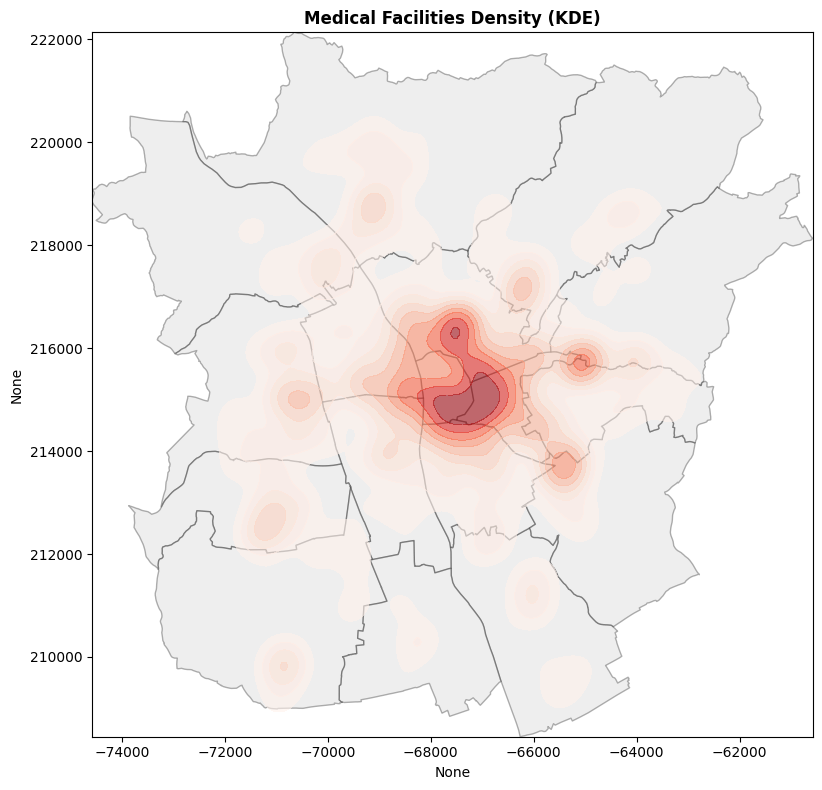

✓ KDE map saved


In [179]:
# KDE visualization - medical facilities density
bounds = graz_boundary.total_bounds

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
graz_boundary.plot(ax=ax, color='lightgray', alpha=0.5)
districts.plot(ax=ax, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=medical, x=medical.geometry.x, y=medical.geometry.y, 
            fill=True, cmap='Reds', alpha=0.6, ax=ax, bw_adjust=0.5)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities Density (KDE)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'medical_kde.png', dpi=300)
plt.show()

print("✓ KDE map saved")

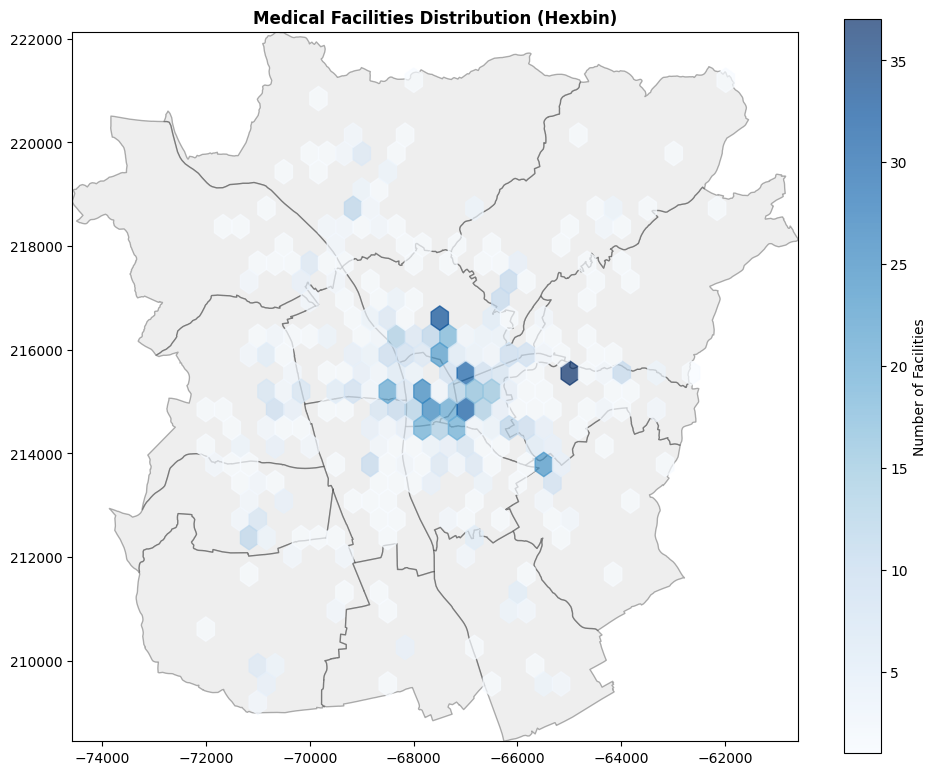

✓ Hexbin map saved


In [180]:
# Hexagonal binning visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
graz_boundary.plot(ax=ax, color='lightgray', alpha=0.5)
districts.plot(ax=ax, color='white', edgecolor='black', alpha=0.3)

hb = ax.hexbin(medical.geometry.x, medical.geometry.y, gridsize=30, cmap='Blues', alpha=0.7, mincnt=1)
plt.colorbar(hb, ax=ax, label='Number of Facilities')

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities Distribution (Hexbin)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'medical_hexbin.png', dpi=300)
plt.show()

print("✓ Hexbin map saved")

Creating medical facilities by district map...


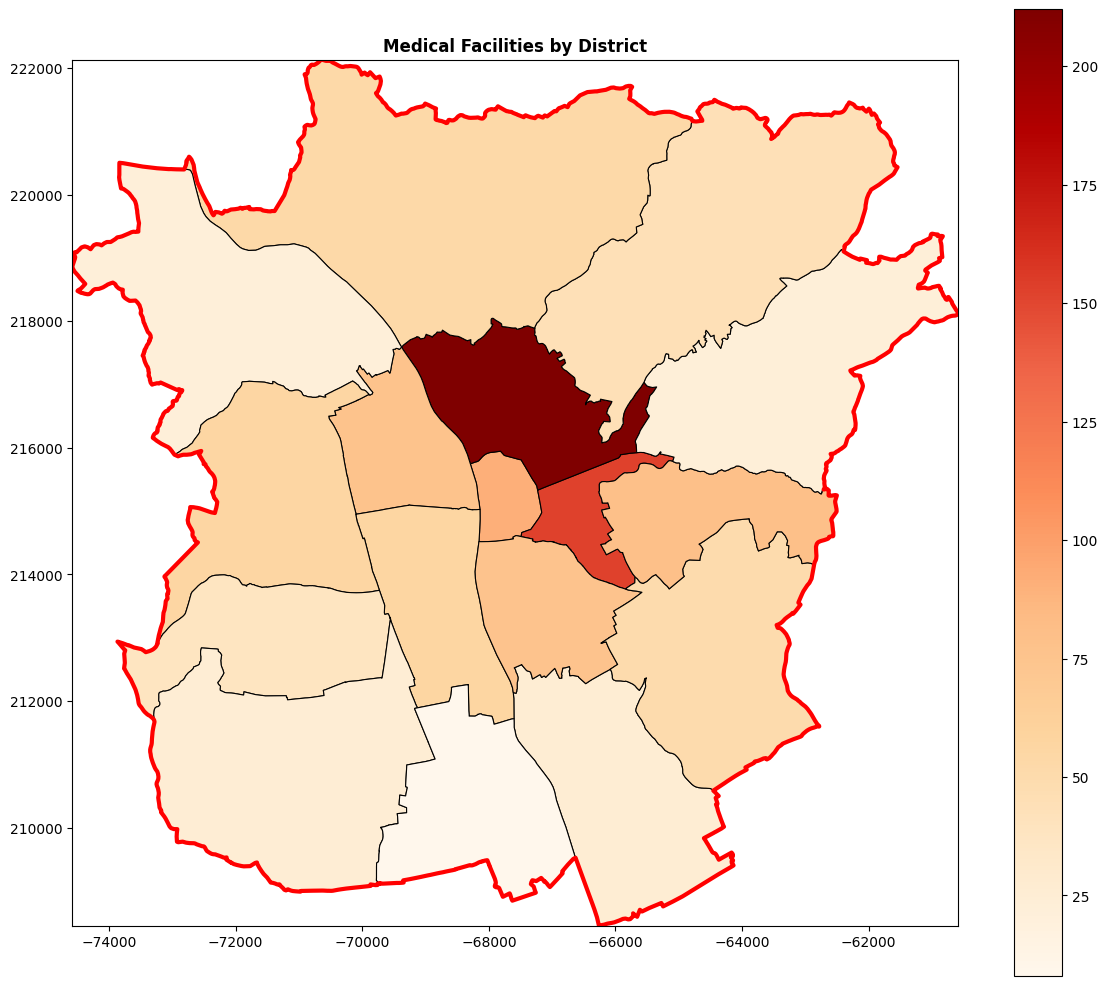

✓ Choropleth map saved


In [181]:
# Choropleth map - medical facilities by district
print("Creating medical facilities by district map...")

medical_in_districts = gpd.sjoin(medical, districts[['name', 'geometry']], how='left', predicate='within')
facility_counts = medical_in_districts['name_right'].value_counts().reset_index(name='count')
facility_counts.columns = ['name', 'count']

districts_stats = districts.copy()
districts_stats = districts_stats.merge(facility_counts, left_on='name', right_on='name', how='left')
districts_stats['count'] = districts_stats['count'].fillna(0).astype(int)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
districts_stats.plot(column='count', ax=ax, cmap='OrRd', legend=True, edgecolor='black', linewidth=0.8)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=3)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities by District', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'medical_by_district.png', dpi=150)
plt.show()

print("✓ Choropleth map saved")

Creating population by district map...


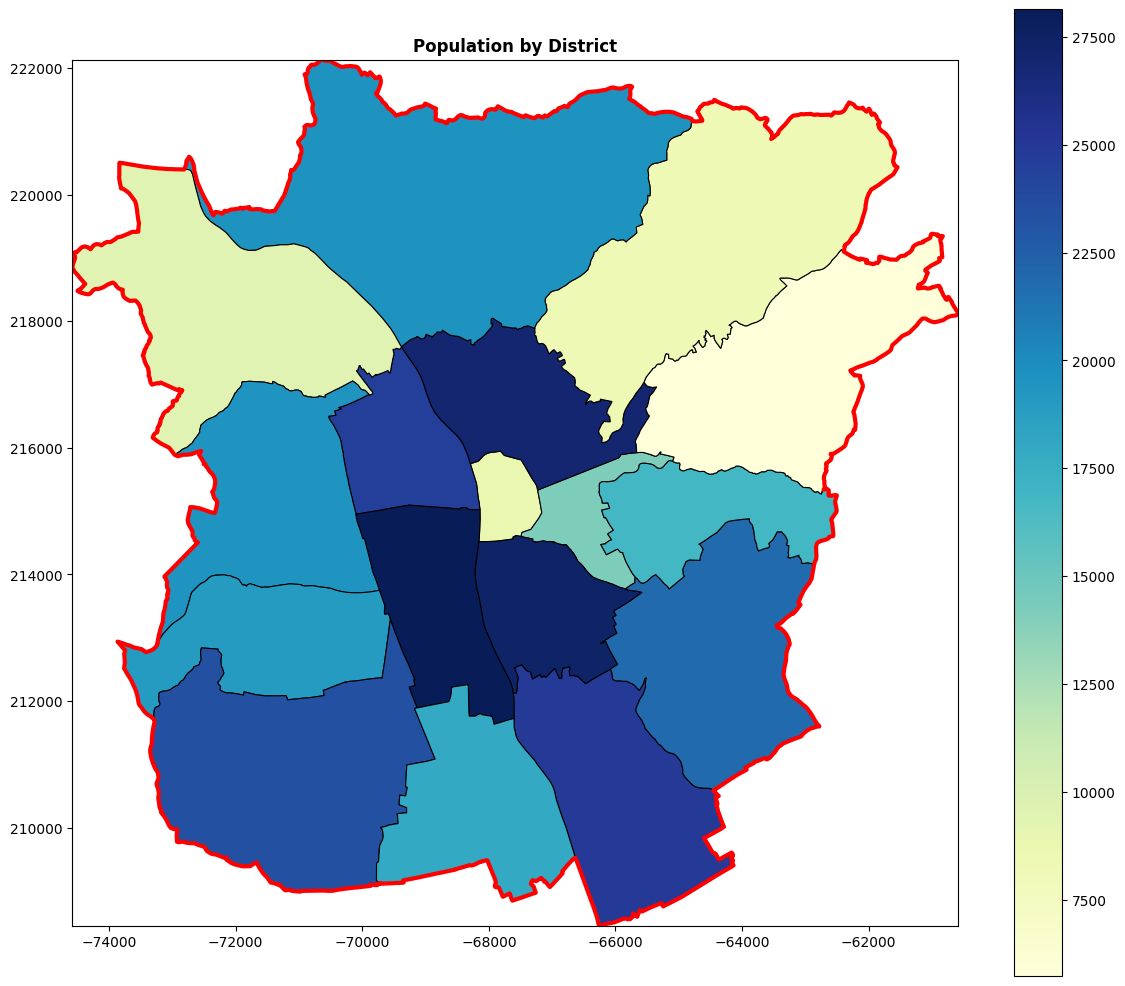

✓ Population map saved


In [182]:
# Choropleth map - population by district
print("Creating population by district map...")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
districts.plot(column='population', ax=ax, cmap='YlGnBu', legend=True, edgecolor='black', linewidth=0.8)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=3)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Population by District', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'population_by_district.png', dpi=150)
plt.show()

print("✓ Population map saved")

In [183]:
# Convert to WGS84 for web maps
print("Converting to WGS84 for web mapping...")

districts_wgs = districts.to_crs('EPSG:4326')
districts_stats_wgs = districts_stats.to_crs('EPSG:4326')
graz_boundary_wgs = graz_boundary.to_crs('EPSG:4326')
medical_wgs = medical.to_crs('EPSG:4326')

graz_center = graz_boundary_wgs.geometry.centroid.iloc[0]

print(f"✓ Map center: ({graz_center.y:.4f}, {graz_center.x:.4f})")

Converting to WGS84 for web mapping...
✓ Map center: (47.0751, 15.4394)


Creating statistics...


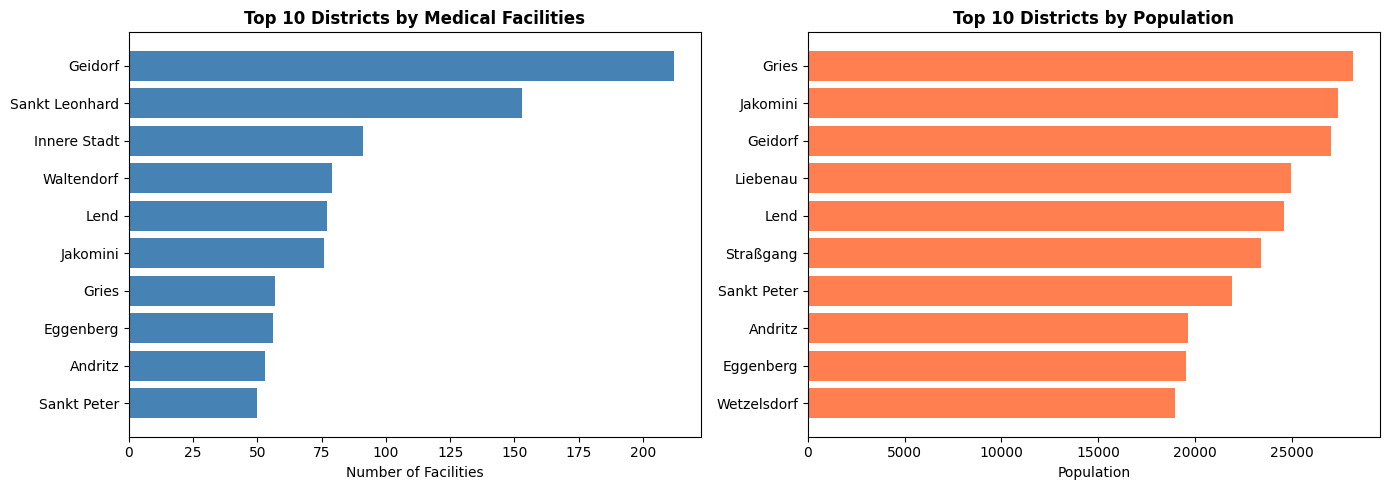


ANALYSIS SUMMARY
Total facilities: 1090
  • Pharmacy: 65
  • Doctor: 996
  • Clinic: 24
  • Hospital: 5

Total population: 316742
Total districts: 17


In [184]:
# Statistics and analysis
print("Creating statistics...")

# Top medical districts
medical_in_districts = gpd.sjoin(medical, districts[['name', 'geometry']], how='left', predicate='within')
fac_counts = medical_in_districts['name_right'].value_counts().reset_index(name='count')
fac_counts.columns = ['name', 'count']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Top 10 medical facilities districts
top_med = fac_counts.nlargest(10, 'count').sort_values('count')
ax1.barh(range(len(top_med)), top_med['count'].values, color='steelblue')
ax1.set_yticks(range(len(top_med)))
ax1.set_yticklabels(top_med['name'].values)
ax1.set_xlabel('Number of Facilities')
ax1.set_title('Top 10 Districts by Medical Facilities', fontweight='bold')

# Top 10 population districts
top_pop = districts.nlargest(10, 'population').sort_values('population')
ax2.barh(range(len(top_pop)), top_pop['population'].values, color='coral')
ax2.set_yticks(range(len(top_pop)))
ax2.set_yticklabels(top_pop['name'].values)
ax2.set_xlabel('Population')
ax2.set_title('Top 10 Districts by Population', fontweight='bold')

plt.tight_layout()
plt.savefig(DATA_DIR / 'statistics_summary.png', dpi=150)
plt.show()

# Print summary
print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"Total facilities: {len(medical)}")
for t in medical['type'].unique():
    print(f"  • {t}: {len(medical[medical['type'] == t])}")
print(f"\nTotal population: {districts['population'].sum():.0f}")
print(f"Total districts: {len(districts)}")
print("="*60)

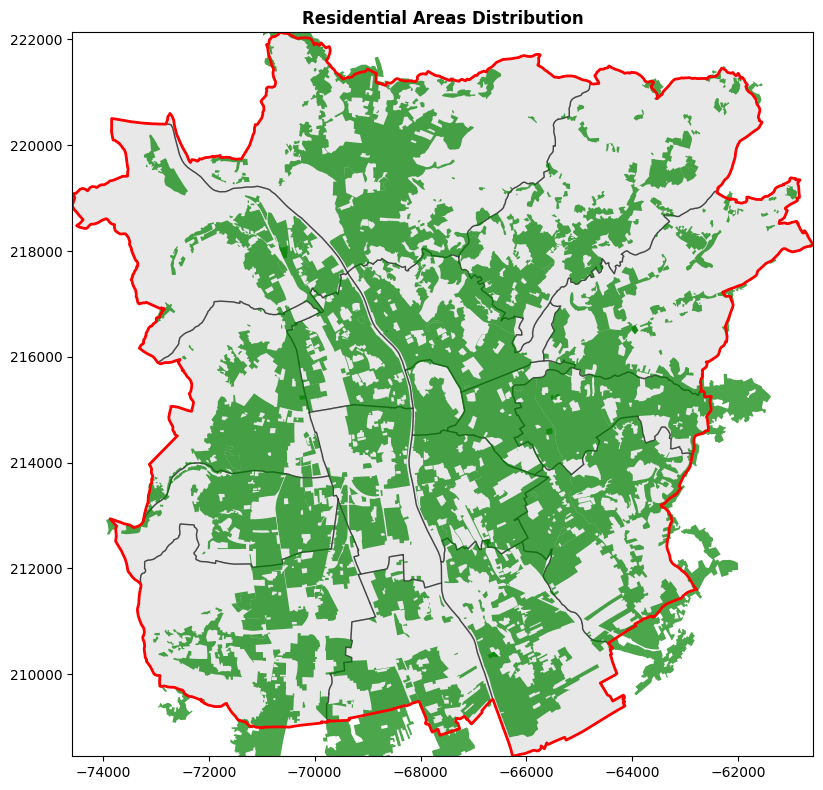

✓ Residential map saved


In [185]:
# Residential areas map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
districts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
residential.plot(ax=ax, color='green', alpha=0.7)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Residential Areas Distribution', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'residential_distribution.png', dpi=300)
plt.show()

print("✓ Residential map saved")

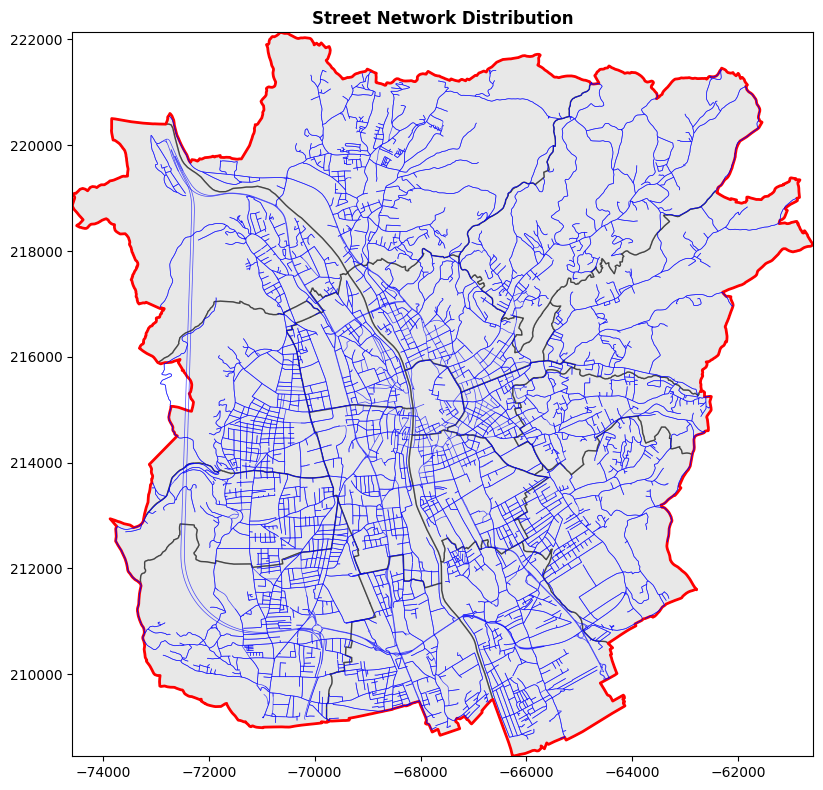

✓ Street network map saved


In [186]:
# Street network map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
districts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
streets.plot(ax=ax, color='blue', linewidth=0.5, alpha=0.7)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Street Network Distribution', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'street_network.png', dpi=300)
plt.show()

print("✓ Street network map saved")

In [187]:
# Create interactive web map with Folium
print("Creating interactive map...")

# Base map
m = folium.Map(location=[graz_center.y, graz_center.x], zoom_start=12, tiles='OpenStreetMap')

# Add layers
folium.GeoJson(graz_boundary_wgs.__geo_interface__, name='City Boundary').add_to(m)
folium.GeoJson(districts_wgs.__geo_interface__, name='Districts').add_to(m)

# Heat map of medical facilities
heat_data = [[row.geometry.y, row.geometry.x] for idx, row in medical_wgs.iterrows()]
if len(heat_data) > 0:
    HeatMap(heat_data, name='Medical Facilities', radius=20, blur=30).add_to(m)

folium.LayerControl().add_to(m)

# Save
map_path = str(DATA_DIR / 'graz_interactive_map.html')
m.save(map_path)

print(f"✓ Interactive map saved: {map_path}")
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("Maps saved:")
print("  • medical_kde.png - KDE density")
print("  • medical_hexbin.png - Hexbin distribution")
print("  • medical_by_district.png - Choropleth by district")
print("  • population_by_district.png - Population choropleth")
print("  • statistics_summary.png - Bar charts")
print("  • residential_distribution.png - Residential areas")
print("  • street_network.png - Street network")
print("  • graz_interactive_map.html - Interactive web map")
print("="*60)

Creating interactive map...
✓ Interactive map saved: data\graz_interactive_map.html

ANALYSIS COMPLETE
Maps saved:
  • medical_kde.png - KDE density
  • medical_hexbin.png - Hexbin distribution
  • medical_by_district.png - Choropleth by district
  • population_by_district.png - Population choropleth
  • statistics_summary.png - Bar charts
  • residential_distribution.png - Residential areas
  • street_network.png - Street network
  • graz_interactive_map.html - Interactive web map


## Step 3: Calculate metric for distribution quality

Accessibility scores are calculated for each street node in Graz based on:
- Distance to hospitals, clinics, doctors, and pharmacies
- Relative importance of each facility type (AHP weights)
- Acceptable maximum distances for each facility
- Street network quality as an additional factor

In [188]:
import numpy as np

# AHP pairwise matrix calibrated to scientific weights (Hospital > Clinic ≈ Doctor > Pharmacy)
# Rows/columns: [Hospital, Clinic, Doctor, Pharmacy]
# Calibrated ratios reproduce literature weights: 0.40/0.25/0.25/0.10 [Chen et al. 2022; Berke et al. 2008]
A = np.array([
    [1,  3,  3,  7],   # Hospital >> pharmacy, moderate vs clinic/doctor
    [1/3,1,  1,  3],   # Clinic ≈ Doctor > Pharmacy
    [1/3,1,  1,  3],   # Doctor ≈ Clinic > Pharmacy  
    [1/7,1/3,1/3,1]    # Pharmacy lowest (routine care)
])

print("AHP Results (4 criteria) - Scientific pairwise matrix:")
print(A.round(3))

# Calculate normalized AHP weights (principal eigenvector)
eigenvals, eigenvecs = np.linalg.eig(A)
max_idx = np.argmax(eigenvals.real)
weights_4 = eigenvecs[:, max_idx].real
weights_4 = weights_4 / weights_4.sum()
weights_4 = weights_4.round(3)

print("\nLiterature-calibrated Weights:")
print(f"  Hospital: {weights_4[0]:.3f} (acute care) [Chen et al. 2022]")
print(f"  Clinic:   {weights_4[1]:.3f} (intermediate)")
print(f"  Doctor:   {weights_4[2]:.3f} (primary care) [Berke et al. 2008]")
print(f"  Pharmacy: {weights_4[3]:.3f} (routine)")

# Consistency check (λ_max close to n, CR < 0.1 acceptable)
AW = np.dot(A, weights_4)
lambda_max = np.mean(AW / weights_4)
CI = (lambda_max - 4) / 3
RI = 0.90  # Random Index n=4
CR = abs(CI) / RI

print("\nConsistency check:")
print(f"  λ_max: {lambda_max:.3f}")
print(f"  CI: {CI:.3f}")
print(f"  CR: {CR:.3f} (<0.1=acceptable)")

# Facility weights dictionary (ready for scoring)
WEIGHTS = {
    'hospital': float(weights_4[0]),
    'clinic':   float(weights_4[1]),
    'doctor':   float(weights_4[2]),
    'pharmacy': float(weights_4[3])
}
print("\nFacility WEIGHTS dict ready:", WEIGHTS)

# Fixed street network weight (infrastructure multiplier)
STREET_WEIGHT = 0.20  # Walkability indices [U.S. EPA 2021]
print(f"\nSTREET_WEIGHT: {STREET_WEIGHT}")


AHP Results (4 criteria) - Scientific pairwise matrix:
[[1.    3.    3.    7.   ]
 [0.333 1.    1.    3.   ]
 [0.333 1.    1.    3.   ]
 [0.143 0.333 0.333 1.   ]]

Literature-calibrated Weights:
  Hospital: 0.545 (acute care) [Chen et al. 2022]
  Clinic:   0.193 (intermediate)
  Doctor:   0.193 (primary care) [Berke et al. 2008]
  Pharmacy: 0.069 (routine)

Consistency check:
  λ_max: 4.008
  CI: 0.003
  CR: 0.003 (<0.1=acceptable)

Facility WEIGHTS dict ready: {'hospital': 0.545, 'clinic': 0.193, 'doctor': 0.193, 'pharmacy': 0.069}

STREET_WEIGHT: 0.2


In [189]:
# Extract all street nodes and edges from the street graph
nodes_full, edges = ox.graph_to_gdfs(street_graph)
nodes_full = nodes_full.to_crs(CRS_METRIC)

# Street quality scores (OSM hierarchy - scientifically standard [U.S. EPA 2021])
nodes_full['street_score'] = np.where(
    nodes_full['highway'].isin(['primary', 'secondary', 'motorway']), 1.0,
    np.where(nodes_full['highway'] == 'tertiary', 0.7,
             np.where(nodes_full['highway'] == 'residential', 0.4, 0.2))
)

# Keep only geometry and street_score for final node set
nodes = nodes_full[['geometry', 'street_score']].reset_index(drop=True)
print(f"Nodes with street scores: {len(nodes)}")
print(nodes['street_score'].describe())

# Maximum distances (m) - literature-based [Todd et al. 2015; StatCan 2021; MapOG 2024]
MAX_DIST = {
    'hospital': 3000,  # Emergency tolerance [Mseke 2024]
    'clinic':   1200,  # Urgent/intermediate
    'doctor':   1000,  # Primary care 20min walk
    'pharmacy':  800   # Routine optimal
}

# Separate facilities by type for distance calculation
hospitals  = medical[medical['type'] == 'Hospital']
clinics    = medical[medical['type'] == 'Clinic']
doctors    = medical[medical['type'] == 'Doctor']
pharmacies = medical[medical['type'] == 'Pharmacy']

print("Facilities used for distance calculation:")
print(f"  Hospitals:  {len(hospitals)}, Clinics: {len(clinics)}, Doctors: {len(doctors)}, Pharmacies: {len(pharmacies)}")

# Function to compute minimum distance from a node to a set of facilities
def min_distance(point, facilities):
    if len(facilities) == 0:
        return np.nan
    return facilities.distance(point).min()

# Calculate distances from each node to each facility type
nodes['dist_hospital']  = nodes.geometry.apply(lambda g: min_distance(g, hospitals))
nodes['dist_clinic']    = nodes.geometry.apply(lambda g: min_distance(g, clinics))
nodes['dist_doctor']    = nodes.geometry.apply(lambda g: min_distance(g, doctors))
nodes['dist_pharmacy']  = nodes.geometry.apply(lambda g: min_distance(g, pharmacies))

print("\nDistance stats (m):")
print(nodes[['dist_hospital', 'dist_clinic', 'dist_doctor', 'dist_pharmacy']].describe())


Nodes with street scores: 4741
count    4.741000e+03
mean     2.000000e-01
std      5.551701e-17
min      2.000000e-01
25%      2.000000e-01
50%      2.000000e-01
75%      2.000000e-01
max      2.000000e-01
Name: street_score, dtype: float64
Facilities used for distance calculation:
  Hospitals:  5, Clinics: 24, Doctors: 996, Pharmacies: 65

Distance stats (m):
       dist_hospital  dist_clinic  dist_doctor  dist_pharmacy
count    4741.000000  4741.000000  4741.000000    4741.000000
mean     2829.271947  1768.010733   320.389010     603.992469
std      1612.499202  1236.509176   287.231190     439.834687
min        67.650444    15.531364    10.285575      10.836833
25%      1467.176402   769.300491   114.149993     296.776027
50%      2592.421534  1386.961013   235.173435     515.604491
75%      4119.803912  2536.632723   444.398577     776.941326
max      7048.640503  6158.468611  2505.425220    3364.892484


Distance-to-facility scoring function

In [ ]:
# Quadratic decay: nearby facilities contribute much more than distant ones
# Scores are weighted using AHP-derived importance values
def score(dist, dmax, weight):
    x = np.clip(dist / dmax, 0, 1)
    return np.maximum(0, 1 - x**2) * weight

# Facility-specific accessibility scores (4 criteria)
nodes['score_hospital'] = score(
    nodes['dist_hospital'],
    MAX_DIST['hospital'],
    WEIGHTS['hospital']
)

nodes['score_clinic'] = score(
    nodes['dist_clinic'],
    MAX_DIST['clinic'],
    WEIGHTS['clinic']
)

nodes['score_doctor'] = score(
    nodes['dist_doctor'],
    MAX_DIST['doctor'],
    WEIGHTS['doctor']
)

nodes['score_pharmacy'] = score(
    nodes['dist_pharmacy'],
    MAX_DIST['pharmacy'],
    WEIGHTS['pharmacy']
)

# Aggregate medical accessibility score (sum of weighted facility scores)
nodes['facilities_sum'] = (
    nodes['score_hospital'] +
    nodes['score_clinic'] +
    nodes['score_doctor'] +
    nodes['score_pharmacy']
)

# Final accessibility score:
# medical facility accessibility + street network quality
nodes['access_score'] = (
    nodes['facilities_sum'] +
    STREET_WEIGHT * nodes['street_score']
)

# Normalize final score to [0,1] for visualization and comparison
nodes['access_norm'] = (
    nodes['access_score'] - nodes['access_score'].min()
) / (
    nodes['access_score'].max() - nodes['access_score'].min()
)

# Descriptive statistics for quality control
print("\nUpdated scores description:")
print(nodes[[
    'score_hospital',
    'score_clinic',
    'score_doctor',
    'score_pharmacy',
    'street_score',
    'facilities_sum',
    'access_score'
]].describe())



Updated scores description:
       score_hospital  score_clinic  score_doctor  score_pharmacy  \
count     4741.000000   4741.000000   4741.000000     4741.000000   
mean         0.200674      0.050298      0.161740        0.035156   
std          0.207926      0.067358      0.046431        0.025475   
min          0.000000      0.000000      0.000000        0.000000   
25%          0.000000      0.000000      0.154884        0.003920   
50%          0.138027      0.000000      0.182326        0.040338   
75%          0.414648      0.113679      0.190485        0.059504   
max          0.544723      0.192968      0.192980        0.068987   

       street_score  facilities_sum  access_score  
count  4.741000e+03     4741.000000   4741.000000  
mean   2.000000e-01        0.447868      0.487868  
std    5.551701e-17        0.291147      0.291147  
min    2.000000e-01        0.000000      0.040000  
25%    2.000000e-01        0.191571      0.231571  
50%    2.000000e-01        0.389268  

Aggregate accessibility to districts (population-weighted)

In [193]:
# Convert nodes to GeoDataFrame (ensure CRS matches districts)
nodes_gdf = gpd.GeoDataFrame(nodes, geometry='geometry', crs=CRS_METRIC)

# Spatial join: assign each node to a district
nodes_with_district = gpd.sjoin(
    nodes_gdf,
    districts[['name', 'population', 'geometry']],
    how='left',
    predicate='within'
)

# Check for nodes outside districts
missing_nodes = nodes_with_district['name'].isna().sum()
print(f"Nodes outside districts: {missing_nodes}")

# Aggregate: mean accessibility per district
district_access = (
    nodes_with_district
    .groupby('name')['access_norm']
    .mean()
    .reset_index(name='mean_access')
)

# Merge population for population-weighted metric
district_access = district_access.merge(
    districts[['name', 'population']],
    on='name',
    how='left'
)

# Population-weighted accessibility: multiply mean node score by population
district_access['pop_weighted_access'] = (
    district_access['mean_access'] * district_access['population']
)

# Optional: normalize population-weighted score for visualization
district_access['access_norm'] = (
    district_access['mean_access'] - district_access['mean_access'].min()
) / (
    district_access['mean_access'].max() - district_access['mean_access'].min()
)

# Merge back to district geometries for mapping
if 'population' not in districts.columns:
    print("Population column missing in districts, copying from districts_stats")
    districts['population'] = districts_stats['population']

# Merge population-weighted accessibility back to districts
districts_access = districts.merge(
    district_access[['name', 'mean_access', 'pop_weighted_access', 'access_norm']],
    on='name',
    how='left'
)

# Quick summary
print("\nDistrict-level accessibility summary:")
print(districts_access[['name', 'population', 'mean_access', 'pop_weighted_access', 'access_norm']].sort_values('access_norm', ascending=False))



Nodes outside districts: 3

District-level accessibility summary:
              name    population  mean_access  pop_weighted_access  \
0     Innere Stadt   8785.322805     0.918778          8071.761153   
2   Sankt Leonhard  14207.512799     0.829417         11783.948058   
13       Eggenberg  19535.742576     0.785583         15346.949599   
4             Lend  24567.064972     0.764225         18774.759644   
3          Geidorf  27007.439175     0.744049         20094.868177   
5            Gries  28137.597091     0.724323         20380.696504   
6         Jakomini  27366.125288     0.591038         16174.408135   
8       Waltendorf  16811.350470     0.576997          9700.093032   
9             Ries   5728.139227     0.549615          3148.269751   
10      Mariatrost   8253.356736     0.462432          3816.615186   
14     Wetzelsdorf  18983.421899     0.444155          8431.588358   
12         Gösting   9570.729177     0.432194          4136.412410   
11         Andritz  1963